In [1]:
import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import dlib
import cv2
import torch
from torch.autograd import Variable
import math
import sys
from supplemental_code.supplemental_code import save_obj, render
import matplotlib.pyplot as plt

%matplotlib inline
print(sys.executable)
print(sys.version)
print(sys.version_info)
print(torch.__version__)

C:\Users\Admin\Anaconda3\envs\python38\python.exe
3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)
1.11.0


In [2]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates in TEnsor
    return torch.tensor(coords).float()


def detect_landmark(img):

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    try:
        dets = detector(img.numpy().astype("uint8"), 1)
    except:
        dets = detector(img.astype("uint8"), 1)
    
    #dets = detector(img.astype("uint8"), 1)

    # print("Number of faces detected: {}".format(len(dets)))
    for k, d in enumerate(dets):
        # print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        #     k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        try: 
            shape = predictor(img.numpy().astype("uint8"), d)
        except:
            shape = predictor(img.numpy().astype("uint8"), d)
        #shape = predictor(img.astype("uint8"), d)
        # Draw the face landmarks on the screen.
        return shape_to_np(shape)


## 4.2.3.1

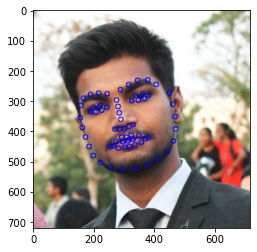

In [12]:
mohit_RGB1 = np.array(Image.open("mohit.jpg"))
mohit_landmarks = detect_landmark(torch.tensor(mohit_RGB1))
for landmark in mohit_landmarks:
    mohit_RGB1 = cv2.circle(mohit_RGB1, landmark.numpy().astype('int'), radius=8, color=(0, 0, 255), thickness=2)
plt.imshow(mohit_RGB1)

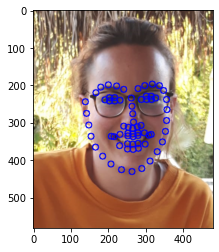

In [10]:
anne = np.array(Image.open("anne.png"))
anne_landmarks = detect_landmark(torch.tensor(anne))
for landmark in anne_landmarks:
    anne = cv2.circle(anne, landmark.numpy().astype('int'), radius=8, color=(0, 0, 255), thickness=2)
plt.imshow(anne)

## 4.2.3.2

In [3]:
torch.autograd.set_detect_anomaly(True)

class EnergyMinimizer(torch.nn.Module):

    def __init__(self):
        super(EnergyMinimizer, self).__init__()
        
        # obtain ground truths
        self.k = np.loadtxt("supplemental_code/Landmarks68_model2017-1_face12_nomouth.anl")
        
        # load trained model and extract PCs
        self.bfm = h5py.File("model2017-1_face12_nomouth.h5",'r')

        self.mean_shape = torch.tensor(np.asarray(self.bfm['shape/model/mean'], dtype=np.float32))
        self.var_shape = torch.tensor(np.asarray(self.bfm['shape/model/pcaVariance'], dtype=np.float32))
        self.PC_shape = torch.tensor(np.asarray(self.bfm['shape/model/pcaBasis'], dtype=np.float32))

        self.mean_expression = torch.tensor(np.asarray(self.bfm['expression/model/mean'], dtype=np.float32))
        self.var_expression = torch.tensor(np.asarray(self.bfm['expression/model/pcaVariance'], dtype=np.float32))
        self.PC_expression = torch.tensor(np.asarray(self.bfm['expression/model/pcaBasis'], dtype=np.float32))

        self.mean_color = torch.tensor(np.asarray(self.bfm['color/model/mean'], dtype=np.float32))
        self.var_color = torch.tensor(np.asarray(self.bfm['color/model/pcaVariance'], dtype=np.float32))
        self.PC_color = torch.tensor(np.asarray(self.bfm['color/model/pcaBasis'], dtype=np.float32))

    def get_3D_face(self, alpha, delta):
        
        obj1 = self.mean_shape.reshape(-1,3) + (self.PC_shape[:,:30] @ (alpha* torch.sqrt(self.var_shape[:30]))).reshape(-1,3)
        obj2 = self.mean_expression.reshape(-1,3) + (self.PC_expression[:,:20] @ (delta* torch.sqrt(self.var_expression[:20]))).reshape(-1,3)
        color = self.mean_color.reshape(-1,3) 
        obj = obj1 + obj2 + color
        
        return obj
    
    def forward(self, alpha, delta, omega, t, scale, ref_centroid):

        face = self.get_3D_face(alpha, delta)
        landmarks = face[self.k]
        transformed_face = face @ omega + t
        transformed_landmarks = landmarks @ omega + t
        projected_landmarks = self.project_2_plane(transformed_landmarks, transformed_face)
        scaled_projected_landmarks = projected_landmarks*scale
        scaled_projected_landmarks[:,0] += ref_centroid[0]
        scaled_projected_landmarks[:,1] += ref_centroid[1]

        return scaled_projected_landmarks[:,:2]
    
    def project_2_plane(self, transformed_landmarks, transformed_face=None):
        
        if type(transformed_face)==type(None):
            minn = torch.min(transformed_landmarks, axis=0).values
            maxx = torch.max(transformed_landmarks, axis=0).values
        else:
            minn = torch.min(transformed_face, axis=0).values
            maxx = torch.max(transformed_face, axis=0).values
                
        vl = minn[0]
        vr = maxx[0]
        vb = minn[1]
        vt = maxx[1]       
        
        width = vr - vl
        heigth = vt - vb
                
        V = torch.tensor([[(vr-vl)/2, 0,0, (vr+vl)/2],[0, (vt-vb)/2, 0, (vt+vb)/2],[0,0, 1/2, 1/2],[0,0,0,1]])

        aspect_ratio = width/heigth
        f = 500
        n = 0.1
        FOV = 0.5
        t = np.tan(FOV/2)*n
        b = -t*aspect_ratio
        r = t*aspect_ratio
        l = -t*aspect_ratio

        P = torch.zeros((4,4))
        P[0][0] = 2*n/(r-l)
        P[1][1] = 2*n/(t-b)
        P[2][2] = -(f+n)/(f-n)
        P[3][3] = 0
        P[0][2] = (r+l)/(r-l)
        P[1][2] = (t+b)/(t-b)
        P[3][2] = -1
        P[2][3] = -(2*f*n)/(f-n)

        homogenous_landmarks = torch.ones((transformed_landmarks.shape[0], transformed_landmarks.shape[1]+1))
        homogenous_landmarks[:,:3] = transformed_landmarks
        
        projected = homogenous_landmarks @((V.T*P).T)

        projected_landmarks = torch.ones((projected.shape[0],  projected.shape[1]-1))
        projected_landmarks[:, 0] = projected[:, 0]/projected[:, 3]
        projected_landmarks[:, 1] = projected[:, 1]/ projected[:, 3]
        projected_landmarks[:, 2] = projected[:, 2]/ projected[:, 3]

        return projected_landmarks

In [4]:
def initialize_variables():
    alpha = Variable(torch.zeros(30)+torch.tensor(0.1), requires_grad=True)  
    delta = Variable(torch.zeros(20)+torch.tensor(0.1), requires_grad=True)
    omega = Variable(torch.eye(3), requires_grad=True)
    t = Variable(torch.tensor([0,0,-5000.0]), requires_grad=True)
    scale = Variable(torch.tensor([2.0]), requires_grad=True)
    return alpha, delta, omega, t, scale

In [7]:
mohit_img = cv2.imread("mohit.jpg", 0)
true_landmarks = detect_landmark(torch.tensor(mohit_img))
ref_H, ref_W = mohit_img.shape
ref_centroid = true_landmarks.mean(axis=0)
ref_min = true_landmarks.min(axis=0).values
ref_max = true_landmarks.max(axis=0).values

In [8]:
print("Loading model....")
EPOCHS = 15000
alpha, delta, omega, t, scale = initialize_variables()

model = EnergyMinimizer()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([alpha, delta, omega, t, scale], lr=0.01)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

for i in range(EPOCHS):
    output = model(alpha, delta, omega, t, scale, ref_centroid)
    
    L_lan = criterion(output, true_landmarks) 
    L_reg = 0.8 * torch.sum(alpha**2) + 0.8 * torch.sum(delta**2)
    loss = L_reg + L_lan
    
    if i%100==0 or i==EPOCHS-1:
        print(f"At iteration {i}: loss is {loss}")
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if loss < 50:
        break

Loading model....
At iteration 0: loss is 6609.66845703125
At iteration 100: loss is 4452.57568359375
At iteration 200: loss is 518.0364990234375


In [42]:
scale

tensor([3.7485], requires_grad=True)

In [43]:
t

tensor([ 3.5743e+00,  1.0692e+00, -4.9980e+03], requires_grad=True)

In [44]:
omega

tensor([[ 1.9421, -0.4829,  2.3620],
        [-0.4860, -1.6412,  0.5006],
        [-0.0558, -0.0567,  3.0511]], requires_grad=True)

In [9]:
obj = model.get_3D_face(alpha, delta)
triangles = np.asarray(model.bfm['shape/representer/cells'], dtype=np.float32)
save_obj(f'PCA_{EPOCHS}.obj', obj.detach().numpy(), model.mean_color.reshape(-1,3).numpy(), triangles.T)

In [135]:
transf_obj = obj @ omega + t
proj_obj = model.project_2_plane(transf_obj)
# proj_obj = proj_obj*scale
proj_obj_min = proj_obj.min(axis=0).values
proj_obj_max = proj_obj.max(axis=0).values
ref_scale_x = (ref_max[0]-ref_min[0])/(proj_obj_max[0]-proj_obj_min[0])
ref_scale_y = (ref_max[1]-ref_min[1])/(proj_obj_max[1]-proj_obj_min[1])
proj_obj[:,0] = proj_obj[:,0]*ref_scale_x
proj_obj[:,1] = proj_obj[:,1]*ref_scale_y
proj_obj[:,0] += ref_centroid[0]
proj_obj[:,1] += ref_centroid[1]

save_obj(f'PCA_{EPOCHS}_planar.obj', proj_obj.detach().numpy(), model.mean_color.reshape(-1,3).numpy(), triangles.T)

In [180]:
ref_scale_y

tensor(3.1081, grad_fn=<DivBackward0>)

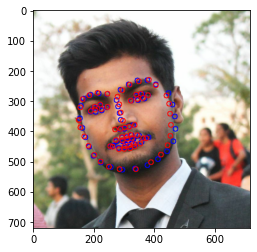

In [47]:
mohit_RGB1 = np.array(Image.open("mohit.jpg"))
for landmark in true_landmarks:
    mohit_RGB1 = cv2.circle(mohit_RGB1, landmark.numpy().astype('int'), radius=8, color=(0, 0, 255), thickness=2)
for landmark in output:
    mohit_RGB1 = cv2.circle(mohit_RGB1, landmark.detach().numpy().astype('int'), radius=8, color=(255, 0, 0), thickness=2)
plt.imshow(mohit_RGB1)

## 4.2.3.3

In [35]:
# lamda_alpha = lamda_delta = 0.8
alpha.max(), alpha.min(), delta.max(), delta.min()

(tensor(1.9748, grad_fn=<MaxBackward1>),
 tensor(-1.5277, grad_fn=<MinBackward1>),
 tensor(1.4610, grad_fn=<MaxBackward1>),
 tensor(-1.0572, grad_fn=<MinBackward1>))

In [42]:
print("Loading model....")
EPOCHS = 15000
alpha, delta, omega, t, scale = initialize_variables()

model = EnergyMinimizer()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([alpha, delta, omega, t, scale], lr=0.01)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

for i in range(EPOCHS):
    output = model(alpha, delta, omega, t, scale, ref_centroid)
    
    L_lan = criterion(output, true_landmarks) 
    L_reg = 0.1 * torch.sum(alpha**2) + 0.1 * torch.sum(delta**2)
    loss = L_reg + L_lan
    
    if i%100==0 or i==EPOCHS-1:
        print(f"At iteration {i}: loss is {loss}")
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if loss < 50:
        break

Loading model....
At iteration 0: loss is 6441.7236328125
At iteration 100: loss is 4013.32373046875
At iteration 200: loss is 319.8758239746094


In [43]:
# lamda_alpha = lamda_delta = 0.1
alpha.max(), alpha.min(), delta.max(), delta.min()

(tensor(2.0849, grad_fn=<MaxBackward1>),
 tensor(-2.4626, grad_fn=<MinBackward1>),
 tensor(2.0919, grad_fn=<MaxBackward1>),
 tensor(-1.6496, grad_fn=<MinBackward1>))

In [44]:
print("Loading model....")
EPOCHS = 15000
alpha, delta, omega, t, scale = initialize_variables()

model = EnergyMinimizer()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([alpha, delta, omega, t, scale], lr=0.01)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

for i in range(EPOCHS):
    output = model(alpha, delta, omega, t, scale, ref_centroid)
    
    L_lan = criterion(output, true_landmarks) 
    L_reg = 0.1 * torch.sum(alpha**2) + 0.8 * torch.sum(delta**2)
    loss = L_reg + L_lan
    
    if i%100==0 or i==EPOCHS-1:
        print(f"At iteration {i}: loss is {loss}")
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if loss < 50:
        break

Loading model....
At iteration 0: loss is 6441.86376953125
At iteration 100: loss is 4016.78466796875
At iteration 200: loss is 323.66265869140625


In [45]:
# lamda_alpha = 0.1; lamda_delta = 0.8
alpha.max(), alpha.min(), delta.max(), delta.min()

(tensor(2.0834, grad_fn=<MaxBackward1>),
 tensor(-2.4952, grad_fn=<MinBackward1>),
 tensor(1.5102, grad_fn=<MaxBackward1>),
 tensor(-1.0909, grad_fn=<MinBackward1>))

In [46]:
print("Loading model....")
EPOCHS = 15000
alpha, delta, omega, t, scale = initialize_variables()

model = EnergyMinimizer()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([alpha, delta, omega, t, scale], lr=0.01)

for i in range(EPOCHS):
    output = model(alpha, delta, omega, t, scale, ref_centroid)
    
    L_lan = criterion(output, true_landmarks) 
    L_reg = 0.8 * torch.sum(alpha**2) + 0.1 * torch.sum(delta**2)
    loss = L_reg + L_lan
    
    if i%100==0 or i==EPOCHS-1:
        print(f"At iteration {i}: loss is {loss}")
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if loss < 50:
        break

Loading model....
At iteration 0: loss is 6441.93359375
At iteration 100: loss is 4028.47265625
At iteration 200: loss is 335.7763671875


In [47]:
# lamda_alpha = 0.8; lamda_delta = 0.1
alpha.max(), alpha.min(), delta.max(), delta.min()

(tensor(1.9773, grad_fn=<MaxBackward1>),
 tensor(-1.5138, grad_fn=<MinBackward1>),
 tensor(2.0860, grad_fn=<MaxBackward1>),
 tensor(-1.7294, grad_fn=<MinBackward1>))

## 4.2.4

In [55]:
image = render(proj_obj[:,:3].detach().numpy(), model.mean_color.reshape(-1,3).numpy(), triangles.T.astype('int'), H=ref_H, W=ref_W)

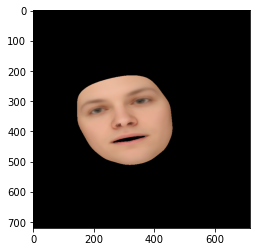

In [56]:
plt.imshow(image)

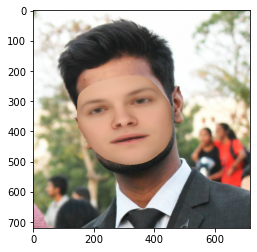

In [121]:
img = np.array(Image.open("mohit.jpg"))
mohit_RGB = np.copy(img)
swapped = np.copy(image)
for x in range(swapped.shape[0]):
    for y in range(swapped.shape[1]):
        if swapped[x][y][0] == 0.0 and swapped[x][y][1] == 0.0 and swapped[x][y][2] == 0.0:
            swapped[x][y] = mohit_RGB[x][y]/255
plt.imshow(swapped)

In [5]:
def bilinear_interpolation(x, y, pixels):
    (x1, y1, q11), (x1, y2, q12), (x2, y1, q21), (x2, y2, q22) = sorted(pixels)
    c_tl = q11*(x2-x)*(y2-y)
    c_tr = q21*(x-x1)*(y2-y)
    c_bl = q12*(x2-x)*(y-y1)
    c_br = q22*(x-x1)*(y-y1)
    c_area = (x2-x1)*(y2-y1)
    c = (c_tl + c_tr + c_bl + c_br) / c_area
    return c

def get_RGB_colors(face_2D, gt_img):
    pred = face_2D[:,:2].T
    color = []
    for pxl in pred.T:
        pxl_color = []
        for i in range(3):
            pxl_y = math.floor(pxl[1])
            pxl_x = math.floor(pxl[0])
            img_color = []
            img_color.append((pxl_y, pxl_x, gt_img[pxl_y][pxl_x][i]))
            img_color.append((pxl_y+1, pxl_x+1, gt_img[pxl_y+1][pxl_x+1][i]))
            img_color.append((pxl_y+1, pxl_x, gt_img[pxl_y+1][pxl_x][i]))
            img_color.append((pxl_y, pxl_x+1, gt_img[pxl_y][pxl_x+1][i]))
            c = bilinear_interpolation(pxl[1], pxl[0], img_color)
            pxl_color.append(int(c))
        color.append(pxl_color)
    return np.stack(color, axis=0)/255

In [167]:
face_2D = proj_obj.detach().numpy()
color_RGB = get_RGB_colors(face_2D, img)

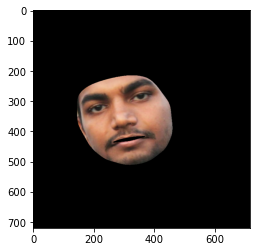

In [168]:
save_obj('2D_texture_{}.obj'.format('mohit'), face_2D, color_RGB, triangles.T.astype('int'))
save_obj('3D_texture_{}.obj'.format('mohit'), transf_obj.detach().numpy(), color_RGB, triangles.T.astype('int'))

textured_image = render(face_2D, color_RGB, triangles.T.astype('int'), H=ref_H, W=ref_W)
plt.imshow(textured_image)

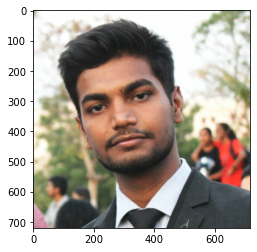

In [157]:
mohit_RGB = np.copy(img)
swapped = np.copy(textured_image)
for x in range(swapped.shape[0]):
    for y in range(swapped.shape[1]):
        if swapped[x][y][0] == 0.0 and swapped[x][y][1] == 0.0 and swapped[x][y][2] == 0.0:
            swapped[x][y] = mohit_RGB[x][y]/255
plt.imshow(swapped)

## 4.2.5

In [190]:
vidcap = cv2.VideoCapture('ref_video.avi')
success,image = vidcap.read()

count = 0
while success:
    cv2.imwrite("test_frames/frame%d.jpg" % count, image)     # save frame as JPG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

In [12]:
count = 100
image_list = [np.array(Image.open(f"test_frames/frame{i}.jpg")) for i in range(count)]
triangles = np.asarray(EnergyMinimizer().bfm['shape/representer/cells'], dtype=np.float32)

In [17]:
def mean_minimizer(images):
    print("Loading model....")
    EPOCHS = 15000
    alpha_list, delta_list, color_list = [],[],[]
    count = 0
    for image in images:
        print(f"\n Processing image {count}...\n")
        
        true_landmarks = detect_landmark(torch.tensor(image))
        ref_H, ref_W, _ = image.shape
        ref_centroid = true_landmarks.mean(axis=0)
        ref_min = true_landmarks.min(axis=0).values
        ref_max = true_landmarks.max(axis=0).values
        
        alpha, delta, omega, t, scale = initialize_variables()
        model = EnergyMinimizer()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam([alpha, delta, omega, t, scale], lr=0.1)

        for i in range(EPOCHS):
            output = model(alpha, delta, omega, t, scale, ref_centroid)

            L_lan = criterion(output, true_landmarks) 
            L_reg = 0.8 * torch.sum(alpha**2) + 0.8 * torch.sum(delta**2)
            loss = L_reg + L_lan

            if i%100==0 or i==EPOCHS-1:
                print(f"At iteration {i}: loss is {loss}")

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            if loss < 100:
                print(f"At iteration {i}: loss is {loss}")
                
                alpha_list.append(alpha.detach().numpy())
                delta_list.append(delta.detach().numpy())
                
                obj = model.get_3D_face(alpha, delta)
                
                transf_obj = obj @ omega + t
                proj_obj = model.project_2_plane(transf_obj)
                
                proj_obj_min = proj_obj.min(axis=0).values
                proj_obj_max = proj_obj.max(axis=0).values
                ref_scale_x = (ref_max[0]-ref_min[0])/(proj_obj_max[0]-proj_obj_min[0])
                ref_scale_y = (ref_max[1]-ref_min[1])/(proj_obj_max[1]-proj_obj_min[1])
                proj_obj[:,0] = proj_obj[:,0]*ref_scale_x
                proj_obj[:,1] = proj_obj[:,1]*ref_scale_y
                proj_obj[:,0] += ref_centroid[0]
                proj_obj[:,1] += ref_centroid[1]
                
                color_RGB = get_RGB_colors(proj_obj.detach().numpy(), image)
                color_list.append(color_RGB)
                
                save_obj(f'3D_face_mean_frame_{count}.obj', obj.detach().numpy(), color_RGB, triangles.T.astype('int'))
                
                image = render(proj_obj[:,:3].detach().numpy(), color_RGB, triangles.T.astype('int'), H=ref_H, W=ref_W)
                PIL_image = Image.fromarray((image * 255).astype(np.uint8))
                PIL_image.save(f"2D_face_mean_frame_{count}.jpeg")
                break
        count += 1
        
    alpha_mean = np.mean(alpha_list, axis=0)
    delta_mean = np.mean(delta_list, axis=0)
    color_mean = np.mean(color_list, axis=0)
    
    print("Done!!!")
    return alpha_mean, delta_mean, color_mean

In [18]:
alpha, delta, color = mean_minimizer(image_list[0:21:5])

Loading model....

 Processing image 0...

At iteration 0: loss is 37228.60546875
At iteration 100: loss is 184.47171020507812
At iteration 200: loss is 100.25069427490234
At iteration 202: loss is 99.86433410644531

 Processing image 1...

At iteration 0: loss is 37288.2265625
At iteration 100: loss is 180.0647735595703
At iteration 183: loss is 99.84049987792969

 Processing image 2...

At iteration 0: loss is 37058.3046875
At iteration 100: loss is 166.01754760742188
At iteration 159: loss is 99.70475769042969

 Processing image 3...

At iteration 0: loss is 35927.765625
At iteration 100: loss is 160.48443603515625
At iteration 154: loss is 99.69136810302734

 Processing image 4...

At iteration 0: loss is 35636.65625
At iteration 100: loss is 156.59637451171875
At iteration 137: loss is 99.98097229003906
Done!!!


In [21]:
obj = EnergyMinimizer().get_3D_face(torch.tensor(alpha), torch.tensor(delta))
save_obj(f'3D_face_mean_min.obj', obj.detach().numpy(), color, triangles.T.astype('int'))

In [36]:
def improvement_minimizer(images):
    print("Loading model....")
    EPOCHS = 15000
    alpha, delta, omega, t, scale = initialize_variables()
    count = 0
    
    for image in images:
        print(f"\n Processing image {count}...\n")
        true_landmarks = detect_landmark(torch.tensor(image))
        ref_H, ref_W, _ = image.shape
        ref_centroid = true_landmarks.mean(axis=0)
        ref_min = true_landmarks.min(axis=0).values
        ref_max = true_landmarks.max(axis=0).values
        
        alpha, delta, omega, t, scale = initialize_variables()
        model = EnergyMinimizer()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam([alpha, delta, omega, t, scale], lr=0.1)
        
        for i in range(EPOCHS):
            output = model(alpha, delta, omega, t, scale, ref_centroid)

            L_lan = criterion(output, true_landmarks) 
            L_reg = 0.8 * torch.sum(alpha**2) + 0.8 * torch.sum(delta**2)
            loss = L_reg + L_lan

            if i%100==0 or i==EPOCHS-1:
                print(f"At iteration {i}: loss is {loss}")

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            if loss < 200:
                print(f"At iteration {i}: loss is {loss}")
                
                obj = model.get_3D_face(alpha, delta)
                
                transf_obj = obj @ omega + t
                proj_obj = model.project_2_plane(transf_obj)
                
                proj_obj_min = proj_obj.min(axis=0).values
                proj_obj_max = proj_obj.max(axis=0).values
                ref_scale_x = (ref_max[0]-ref_min[0])/(proj_obj_max[0]-proj_obj_min[0])
                ref_scale_y = (ref_max[1]-ref_min[1])/(proj_obj_max[1]-proj_obj_min[1])
                proj_obj[:,0] = proj_obj[:,0]*ref_scale_x
                proj_obj[:,1] = proj_obj[:,1]*ref_scale_y
                proj_obj[:,0] += ref_centroid[0]
                proj_obj[:,1] += ref_centroid[1]
                
                color_RGB = get_RGB_colors(proj_obj.detach().numpy(), image)
                
                save_obj(f'3D_face_imp_frame_{count}.obj', obj.detach().numpy(), color_RGB, triangles.T.astype('int'))
                
                image = render(proj_obj[:,:3].detach().numpy(), color_RGB, triangles.T.astype('int'), H=ref_H, W=ref_W)
                PIL_image = Image.fromarray((image * 255).astype(np.uint8))
                PIL_image.save(f"2D_face_imp_frame_{count}.jpeg")
                
                break
        count += 1
    
    return alpha, delta

In [37]:
alpha, delta = improvement_minimizer(image_list[0:21:5])

Loading model....

 Processing image 0...

At iteration 0: loss is 37228.60546875
At iteration 96: loss is 198.49893188476562

 Processing image 1...

At iteration 0: loss is 37288.2265625
At iteration 94: loss is 198.62918090820312

 Processing image 2...

At iteration 0: loss is 37058.3046875
At iteration 89: loss is 198.2425994873047

 Processing image 3...

At iteration 0: loss is 35927.765625
At iteration 87: loss is 199.76089477539062

 Processing image 4...

At iteration 0: loss is 35636.65625
At iteration 90: loss is 198.14022827148438


In [38]:
obj = EnergyMinimizer().get_3D_face(alpha.clone().detach(), delta.clone().detach())
save_obj(f'3D_face_imp_min.obj', obj.detach().numpy(), color, triangles.T.astype('int'))

## 4.2.6

In [48]:
def img_swap(source_path, target_path, expression="source", lr=0.1, imshow=False):
    print("Loading images...")
    target_RGB = np.array(Image.open(target_path))
    source_RGB = np.array(Image.open(source_path))
    
    source_landmarks = detect_landmark(torch.tensor(source_RGB))
    target_landmarks = detect_landmark(torch.tensor(target_RGB))
    
    source_centroid = source_landmarks.mean(axis=0)
    target_centroid = target_landmarks.mean(axis=0)
    
    source_H, source_W, _ = source_RGB.shape
    source_min = source_landmarks.min(axis=0).values
    source_max = source_landmarks.max(axis=0).values
    
    target_H, target_W, _ = target_RGB.shape
    target_min = target_landmarks.min(axis=0).values
    target_max = target_landmarks.max(axis=0).values
    
    EPOCHS = 15000
    criterion = torch.nn.MSELoss()
    
    print("Loading model....")
    alpha1, delta1, omega1, t1, scale1 = initialize_variables()
    model = EnergyMinimizer()
    optimizer = torch.optim.Adam([alpha1, delta1, omega1, t1, scale1], lr=lr)
    
    print("Training model on source image....")
    for i in range(EPOCHS):
        output = model(alpha1, delta1, omega1, t1, scale1, source_centroid)

        L_lan = criterion(output, source_landmarks) 
        L_reg = 0.8 * torch.sum(alpha1**2) + 0.3 * torch.sum(delta1**2)
        loss = L_reg + L_lan

        if i%100==0 or i==EPOCHS-1:
            print(f"At iteration {i}: loss is {loss}")

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if loss < 100:
            print(f"At iteration {i}: loss is {loss}")
            print("Training completed")
            break
            
    print("Loading model....")
    model = EnergyMinimizer()
    alpha2, delta2, omega2, t2, scale2 = initialize_variables()
    optimizer = torch.optim.Adam([alpha2, delta2, omega2, t2, scale2], lr=lr)

    print("Training model on target image....")
    for i in range(EPOCHS):
        output = model(alpha2, delta2, omega2, t2, scale2, target_centroid)

        L_lan = criterion(output, target_landmarks) 
        L_reg = 0.8 * torch.sum(alpha2**2) + 0.3 * torch.sum(delta2**2)
        loss = L_reg + L_lan

        if i%100==0 or i==EPOCHS-1:
            print(f"At iteration {i}: loss is {loss}")

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if loss < 100:
            print(f"At iteration {i}: loss is {loss}")
            print("Training completed")
            break
            
    # getting colors
    obj1 = model.get_3D_face(alpha1, delta1)
    transf_obj1 = obj1 @ omega1 + t1
    proj_obj1 = model.project_2_plane(transf_obj1)
    proj_obj_min1 = proj_obj1.min(axis=0).values
    proj_obj_max1 = proj_obj1.max(axis=0).values
    source_scale_x = (source_max[0]-source_min[0])/(proj_obj_max1[0]-proj_obj_min1[0])
    source_scale_y = (source_max[1]-source_min[1])/(proj_obj_max1[1]-proj_obj_min1[1])
    proj_obj1[:,0] = proj_obj1[:,0]*source_scale_x
    proj_obj1[:,1] = proj_obj1[:,1]*source_scale_y
    proj_obj1[:,0] += source_centroid[0]
    proj_obj1[:,1] += source_centroid[1]
    color_RGB = get_RGB_colors(proj_obj1.detach().numpy(), source_RGB)
    
    #building geometry
    if expression=="source":
        obj = model.get_3D_face(alpha1, delta1)
    else:
        obj = model.get_3D_face(alpha1, delta2)
    triangles = np.asarray(model.bfm['shape/representer/cells'], dtype=np.float32)
    transf_obj = obj @ omega2 + t2
    proj_obj = model.project_2_plane(transf_obj)
    proj_obj_min = proj_obj.min(axis=0).values
    proj_obj_max = proj_obj.max(axis=0).values
    target_scale_x = (target_max[0]-target_min[0])/(proj_obj_max[0]-proj_obj_min[0])
    target_scale_y = (target_max[1]-target_min[1])/(proj_obj_max[1]-proj_obj_min[1])
    proj_obj[:,0] = proj_obj[:,0]*target_scale_x
    proj_obj[:,1] = proj_obj[:,1]*target_scale_y
    proj_obj[:,0] += target_centroid[0]
    proj_obj[:,1] += target_centroid[1]
    
    # getting final image
    swapped = render(proj_obj[:,:3].detach().numpy(), color_RGB, triangles.T.astype('int'), H=target_H, W=target_W)
    
    plt.imshow(swapped)
    
    for x in range(swapped.shape[0]):
        for y in range(swapped.shape[1]):
            if swapped[x][y][0] == 0.0 and swapped[x][y][1] == 0.0 and swapped[x][y][2] == 0.0:
                swapped[x][y] = target_RGB[x][y]/255
    
    if imshow==True:
        plt.imshow(swapped)
    return swapped

Loading images...
Loading model....
Training model on source image....
At iteration 0: loss is 6620.3857421875
At iteration 46: loss is 96.85389709472656
Training completed
Loading model....
Training model on target image....
At iteration 0: loss is 4008.497314453125
At iteration 41: loss is 90.79936218261719
Training completed


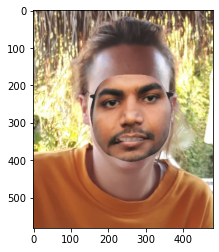

In [49]:
swapped_2img = img_swap("mohit.jpg", "anne.png", expression="target", imshow=True)

Loading images...
Loading model....
Training model on source image....
At iteration 0: loss is 6620.3857421875
At iteration 46: loss is 96.85389709472656
Training completed
Loading model....
Training model on target image....
At iteration 0: loss is 4008.497314453125
At iteration 41: loss is 90.79936218261719
Training completed


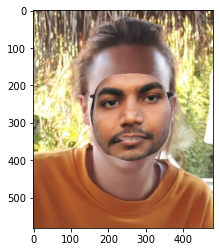

In [50]:
swapped_2img = img_swap("mohit.jpg", "anne.png", expression="source", imshow=True)

Loading images...
Loading model....
Training model on source image....
At iteration 0: loss is 4008.497314453125
At iteration 41: loss is 90.79936218261719
Training completed
Loading model....
Training model on target image....
At iteration 0: loss is 6620.3857421875
At iteration 46: loss is 96.85389709472656
Training completed


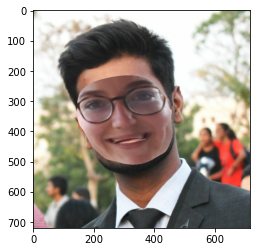

In [51]:
swapped_2img = img_swap("anne.png","mohit.jpg", expression="target", imshow=True)

Loading images...
Loading model....
Training model on source image....
At iteration 0: loss is 4008.497314453125
At iteration 41: loss is 90.79936218261719
Training completed
Loading model....
Training model on target image....
At iteration 0: loss is 6620.3857421875
At iteration 46: loss is 96.85389709472656
Training completed


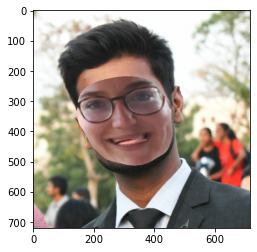

In [52]:
swapped_2img = img_swap("anne.png","mohit.jpg", expression="source", imshow=True)

## 4.3

In [56]:
vidcap = cv2.VideoCapture('swapping_video~1.mp4') #15 fps
success,image = vidcap.read()

count = 0
while success:
    cv2.imwrite("gold_std/frame%d.jpg" % count, image)     # save frame as JPG file      
    success,image = vidcap.read()
    count += 1

In [6]:
source = np.array(Image.open("anne.png"))
source_landmarks = detect_landmark(torch.tensor(source))
source_centroid = source_landmarks.mean(axis=0)

source_min = source_landmarks.min(axis=0).values
source_max = source_landmarks.max(axis=0).values

print("Loading model....")
alpha1, delta1, omega1, t1, scale1 = initialize_variables()
model = EnergyMinimizer()
optimizer = torch.optim.Adam([alpha1, delta1, omega1, t1, scale1], lr=0.1)
EPOCHS = 1500
criterion = torch.nn.MSELoss()

print("Training model on source image....")
for i in range(EPOCHS):
    output = model(alpha1, delta1, omega1, t1, scale1, source_centroid)

    L_lan = criterion(output, source_landmarks) 
    L_reg = 0.8 * torch.sum(alpha1**2) + 0.5 * torch.sum(delta1**2)
    loss = L_reg + L_lan

    if i%100==0 or i==EPOCHS-1:
        print(f"At iteration {i}: loss is {loss}")

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    if loss < 100:
        print(f"At iteration {i}: loss is {loss}")
        print("Training completed")
        break
        
# getting colors
obj1 = model.get_3D_face(alpha1, delta1)
transf_obj1 = obj1 @ omega1 + t1
proj_obj1 = model.project_2_plane(transf_obj1)
proj_obj_min1 = proj_obj1.min(axis=0).values
proj_obj_max1 = proj_obj1.max(axis=0).values
source_scale_x = (source_max[0]-source_min[0])/(proj_obj_max1[0]-proj_obj_min1[0])
source_scale_y = (source_max[1]-source_min[1])/(proj_obj_max1[1]-proj_obj_min1[1])
proj_obj1[:,0] = proj_obj1[:,0]*source_scale_x
proj_obj1[:,1] = proj_obj1[:,1]*source_scale_y
proj_obj1[:,0] += source_centroid[0]
proj_obj1[:,1] += source_centroid[1]
color = get_RGB_colors(proj_obj1.detach().numpy(), source)
print("Got source colors too!")

Loading model....
Training model on source image....
At iteration 0: loss is 4008.537353515625
At iteration 41: loss is 92.40145111083984
Training completed
Got source colors too!


In [13]:
expression="target"
alpha2, delta2, omega2, t2, scale2 = initialize_variables()

for j in range(902):   
    target = np.array(Image.open(f"gold_std/frame{j}.jpg"))
    target_landmarks = detect_landmark(torch.tensor(target))
    if type(target_landmarks)!=type(None):
        ref_H, ref_W, _ = target.shape
        ref_centroid = target_landmarks.mean(axis=0)
        ref_min = target_landmarks.min(axis=0).values
        ref_max = target_landmarks.max(axis=0).values

        print("Loading model....")
        model = EnergyMinimizer()
        optimizer = torch.optim.Adam([alpha2, delta2, omega2, t2, scale2], lr=1)

        print(f"Training model on gold_std/frame{j}.jpg....")
        for i in range(EPOCHS):
            output = model(alpha2, delta2, omega2, t2, scale2, ref_centroid)

            L_lan = criterion(output, target_landmarks) 
            L_reg = 0.8 * torch.sum(alpha2**2) + 0.3 * torch.sum(delta2**2)
            loss = L_reg + L_lan

            if i%100==0 or i==EPOCHS-1:
                print(f"At iteration {i}: loss is {loss}")

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

            if loss < 200:
                print(f"At iteration {i}: loss is {loss}")
                print("Training completed")
                break

        obj = model.get_3D_face(alpha1, delta2)
        triangles = np.asarray(model.bfm['shape/representer/cells'], dtype=np.float32)

        transf_obj = obj @ omega2 + t2
        proj_obj = model.project_2_plane(transf_obj)
        proj_obj_min = proj_obj.min(axis=0).values
        proj_obj_max = proj_obj.max(axis=0).values
        ref_scale_x = (ref_max[0]-ref_min[0])/(proj_obj_max[0]-proj_obj_min[0])
        ref_scale_y = (ref_max[1]-ref_min[1])/(proj_obj_max[1]-proj_obj_min[1])
        proj_obj[:,0] = proj_obj[:,0]*ref_scale_x
        proj_obj[:,1] = proj_obj[:,1]*ref_scale_y
        proj_obj[:,0] += ref_centroid[0]
        proj_obj[:,1] += ref_centroid[1]

        swapped = render(proj_obj[:,:3].detach().numpy(), color, triangles.T.astype('int'), H=ref_H, W=ref_W)

        for x in range(swapped.shape[0]):
            for y in range(swapped.shape[1]):
                if swapped[x][y][0] == 0.0 and swapped[x][y][1] == 0.0 and swapped[x][y][2] == 0.0:
                    swapped[x][y] = target[x][y]/255

        im = Image.fromarray((swapped*255).astype(np.uint8))
        im.save(f"processed/frame{j}_processed.jpg")

        print(f"Saving processed gold_std/frame{j}.jpg")

Loading model....
Training model on gold_std/frame754.jpg....
At iteration 0: loss is 1319.725830078125
At iteration 49: loss is 187.85809326171875
Training completed
Saving processed gold_std/frame754.jpg
Loading model....
Training model on gold_std/frame755.jpg....
At iteration 0: loss is 198.84556579589844
At iteration 0: loss is 198.84556579589844
Training completed
Saving processed gold_std/frame755.jpg
Loading model....
Training model on gold_std/frame756.jpg....
At iteration 0: loss is 9737.31640625
At iteration 100: loss is 1059.80810546875
At iteration 200: loss is 627.2833862304688
At iteration 300: loss is 400.94622802734375
At iteration 305: loss is 135.11778259277344
Training completed
Saving processed gold_std/frame756.jpg
Loading model....
Training model on gold_std/frame757.jpg....
At iteration 0: loss is 84.55917358398438
At iteration 0: loss is 84.55917358398438
Training completed
Saving processed gold_std/frame757.jpg
Loading model....
Training model on gold_std/fram

Saving processed gold_std/frame787.jpg
Loading model....
Training model on gold_std/frame788.jpg....
At iteration 0: loss is 10891.7900390625
At iteration 100: loss is 720.69677734375
At iteration 200: loss is 578.7195434570312
At iteration 233: loss is 193.70944213867188
Training completed
Saving processed gold_std/frame788.jpg
Loading model....
Training model on gold_std/frame789.jpg....
At iteration 0: loss is 188.36761474609375
At iteration 0: loss is 188.36761474609375
Training completed
Saving processed gold_std/frame789.jpg
Loading model....
Training model on gold_std/frame790.jpg....
At iteration 0: loss is 5688.40087890625
At iteration 100: loss is 742.3594970703125
At iteration 190: loss is 194.35073852539062
Training completed
Saving processed gold_std/frame790.jpg
Loading model....
Training model on gold_std/frame791.jpg....
At iteration 0: loss is 171.4976043701172
At iteration 0: loss is 171.4976043701172
Training completed
Saving processed gold_std/frame791.jpg
Loading m

At iteration 2: loss is 177.8078155517578
Training completed
Saving processed gold_std/frame825.jpg
Loading model....
Training model on gold_std/frame826.jpg....
At iteration 0: loss is 462.7419128417969
At iteration 2: loss is 183.3756561279297
Training completed
Saving processed gold_std/frame826.jpg
Loading model....
Training model on gold_std/frame827.jpg....
At iteration 0: loss is 458.0591735839844
At iteration 2: loss is 181.0065460205078
Training completed
Saving processed gold_std/frame827.jpg
Loading model....
Training model on gold_std/frame828.jpg....
At iteration 0: loss is 458.5340881347656
At iteration 2: loss is 196.72293090820312
Training completed
Saving processed gold_std/frame828.jpg
Loading model....
Training model on gold_std/frame829.jpg....
At iteration 0: loss is 486.32861328125
At iteration 2: loss is 182.44374084472656
Training completed
Saving processed gold_std/frame829.jpg
Loading model....
Training model on gold_std/frame830.jpg....
At iteration 0: loss i

At iteration 0: loss is 463.814697265625
At iteration 2: loss is 165.43125915527344
Training completed
Saving processed gold_std/frame865.jpg
Loading model....
Training model on gold_std/frame866.jpg....
At iteration 0: loss is 399.372802734375
At iteration 2: loss is 144.22564697265625
Training completed
Saving processed gold_std/frame866.jpg
Loading model....
Training model on gold_std/frame867.jpg....
At iteration 0: loss is 449.17584228515625
At iteration 2: loss is 151.06060791015625
Training completed
Saving processed gold_std/frame867.jpg
Loading model....
Training model on gold_std/frame868.jpg....
At iteration 0: loss is 396.5289306640625
At iteration 2: loss is 135.4784393310547
Training completed
Saving processed gold_std/frame868.jpg
Loading model....
Training model on gold_std/frame869.jpg....
At iteration 0: loss is 432.3934020996094
At iteration 2: loss is 150.68807983398438
Training completed
Saving processed gold_std/frame869.jpg
Loading model....
Training model on gol

In [15]:
#video writing code is taken from:
#https://stackoverflow.com/questions/44947505/how-to-make-a-movie-out-of-images-in-python
import os

image_folder = 'processed'
video_name = 'processed_video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
# vidcap = cv2.VideoCapture('ref_video.avi')
# fps = int(vidcap.get(cv2.CAP_PROP_FPS))

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 15, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()